# ロジスティック回帰
## 欠損値補完
* Fare: 欠損レコードの「Pclass=3」「Embarked=S」の平均運賃(=14.43)で補完
* Embarked: 欠損レコードは共に「Pclass=1st」。条件付き確率の最も高い「S」で補完

## 外れ値処理
* SibSp: 4以上は4に丸める
* Parch: 3以上は3に丸める
* Fare: 80以上(概ね上位10%点)は80に丸める

## 特徴量
* Pclass: そのまま利用
* Sex: ダミー変数化
* Age: 「5才以下」「5〜15才(2nd以上)」「5〜10才（3rd）」「10〜15才（3rd）」「15〜60才」「60才以上」「欠損値」「推定値」
* SibSp: 「SibSp(外れ値処理済)」「SibSp=0フラグ」
* Parch: 「Parch(外れ値処理済)」「Parch=0フラグ」
* Fare: 外れ値処理をした値を利用
* Embarked: ダミー変数化

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from titanic_package.titanic_preprocess import get_age_ctgr
from titanic_package.titanic_preprocess import get_binned_data
from titanic_package.titanic_plot import plot_survival_rate

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data load
titanic_train = pd.read_csv('./data/train.csv')
titanic_test = pd.read_csv('./data/test.csv')

In [3]:
# 学習/評価データをマージ
titanic_train['Type'] = 'train'
titanic_test['Type'] = 'test'
titanic_test['Survived'] = np.NaN

titanic_all = pd.concat([titanic_train, titanic_test], ignore_index=True, sort=True)
train_flg = titanic_all['Type'] == 'train'
test_flg = titanic_all['Type'] == 'test'

In [4]:
# 欠損値補完
# Fare
## 運賃は「チケットクラス」「乗船港」で決まると考える
## 欠損レコードは「Pclass=3」「Embarked=S」なのでその平均運賃で補完する
f = (titanic_all['Pclass'] == 3) & (titanic_all['Embarked'] == 'S')
fare_mean = np.mean(titanic_all[f]['Fare'].dropna())

titanic_all['Fare'] = titanic_all['Fare'].fillna(fare_mean)

# Embarked
## 欠損の2人は1stクラス。条件付き確率が最も高い「S」で補完
titanic_all['Embarked'] = titanic_all['Embarked'].fillna('S')

In [5]:
# 外れ値処理
titanic_all['SibSp_rounded'] = titanic_all['SibSp'].apply(lambda x: min(4, x))
titanic_all['Parch_rounded'] = titanic_all['Parch'].apply(lambda x: min(3, x))
titanic_all['Fare_rounded'] = titanic_all['Fare'].apply(lambda x: min(80, x))

In [6]:
# 年齢カテゴリを作成
## 「5才以下」「5〜15才(2nd以上)」「5〜10才（3rd）」「10〜15才（3rd）」「15〜60才」「60才以上」「欠損値」「推定値」
age_ctgr_list = []

for index, row in titanic_all.iterrows():
    age_ctgr = get_age_ctgr(row['Age'], row['Pclass'])
    age_ctgr_list.append(age_ctgr)

titanic_all['AgeCtgr'] = age_ctgr_list

In [7]:
# SibSp=0フラグを作成
titanic_all['SibSp=0'] = titanic_all['SibSp'].apply(lambda x: 1 if x == 0 else 0)

In [8]:
# Parch=0フラグを作成
titanic_all['Parch=0'] = titanic_all['Parch'].apply(lambda x: 1 if x == 0 else 0)

In [9]:
# ダミー変数化
X_dummy = pd.DataFrame()

## 性別
dummy_df = pd.get_dummies(titanic_all['Sex']).drop('male', axis=1)
dummy_df.columns = ['Sex_female']
X_dummy = pd.concat([X_dummy, dummy_df], axis=1)

## 年齢カテゴリ
dummy_df = pd.get_dummies(titanic_all['AgeCtgr']).drop('15-60', axis=1)
dummy_df.columns = ['AgeCtgr_' + name for name in dummy_df.columns]
X_dummy = pd.concat([X_dummy, dummy_df], axis=1)

## SibSp=0, Parch=0フラグ
X_dummy = pd.concat([X_dummy, titanic_all[['SibSp=0', 'Parch=0']]], axis=1)

## 乗船港
dummy_df = pd.get_dummies(titanic_all['Embarked']).drop('S', axis=1)
dummy_df.columns = ['Embarked_' + name for name in dummy_df.columns]
X_dummy = pd.concat([X_dummy, dummy_df], axis=1)

In [10]:
# 数値データ
numeric_columns = ['Pclass', 'SibSp_rounded', 'Parch_rounded', 'Fare_rounded']
X_numeric = titanic_all[numeric_columns]

In [11]:
# 学習／テスト用データに分割
X = pd.concat([X_numeric, X_dummy], axis=1)

X_train = X[train_flg]
y_train = titanic_all[train_flg]['Survived'].astype(int)

X_test = X[test_flg]

In [12]:
# 相関を確認
cor_matrix = X_train.corr()

# リスト形式に変換
cor_list = pd.DataFrame()

for i, col1 in enumerate(X_train.columns):
    for j in range(i+1, len(X_train.columns)):
        col2 = X_train.columns[j]
        cor = cor_matrix[col1][col2]
        cor_df = pd.DataFrame([[col1, col2, cor]])
        
        cor_list = pd.concat([cor_list,  cor_df], axis=0)

cor_list.columns = ['Feature1', 'Feature2', 'cor']
cor_list.reset_index(drop=True, inplace=True)
cor_list['abs_cor'] = abs(cor_list['cor'])
cor_list.sort_values(by='abs_cor', ascending=False, inplace=True)

# 相関係数（絶対値）のTop5
cor_list[0:5]

,Feature1,Feature2,cor,abs_cor
39,Parch_rounded,Parch=0,-0.904170,0.904170
25,SibSp_rounded,SibSp=0,-0.784494,0.784494
2,Pclass,Fare_rounded,-0.712412,0.712412
26,SibSp_rounded,Parch=0,-0.488299,0.488299
15,SibSp_rounded,Parch_rounded,0.468342,0.468342


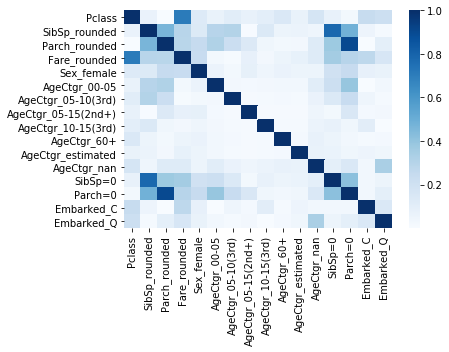

In [13]:
# 相関行列をheatmapで表示
abs_cor_matrix = abs(cor_matrix)

sns.heatmap(abs_cor_matrix,
            xticklabels=X_train.columns,
            yticklabels=X_train.columns,
            cmap='Blues'
           )

In [14]:
# 正則化ロジスティック回帰を使うため標準化を行う
sc = StandardScaler()
sc.fit(X_train.astype(float))

X_scaled_train = pd.DataFrame(sc.transform(X_train.astype(float)))
X_scaled_train.columns = X_train.columns

X_scaled_test = pd.DataFrame(sc.transform(X_test.astype(float)))
X_scaled_test.columns = X_test.columns

# ロジスティック回帰
* パラメタ
  * C=0.089, LogLoss=0.443
* accuracy(validation): 0.806
* accuracy(test): 0.775

In [15]:
# モデルチューニング
model = LogisticRegression(solver='lbfgs')

C_params = np.logspace(-4, 4, 20)
parameters = {
    'C': C_params
}

# パラメタチューニング
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

model_tuning = GridSearchCV(
    estimator = model,   # 識別器
    param_grid = parameters,    # パラメタ
    scoring=['neg_log_loss', 'accuracy'],    # LogLoss, accuracyで評価
    refit = 'neg_log_loss',       # LogLoss最小パラメタで学習データ全体を再学習
    cv = skf,                      # Stratified Cross validation                      
    n_jobs = -1,               # 並列実行数(-1: コア数で並列実行)
    verbose = 0,                # メッセージ出力レベル
    iid = False,
)

model_tuning.fit(X_scaled_train, y_train)
model = model_tuning.best_estimator_

best C: 0.089
best Log Loss: 0.443
Accuracy: 0.806


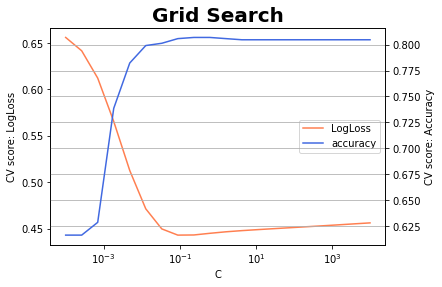

In [16]:
# チューニング結果をplot
## Negative Log LossなのでLog Lossに変換する
score_values = -model_tuning.cv_results_['mean_test_neg_log_loss']

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.set_xlabel('C')
ax1.set_xscale('log')

# LogLoss
ax1.plot(C_params, score_values, color='coral', label='LogLoss')
ax1.set_ylabel('CV score: LogLoss')

# accuracy
ax2.plot(C_params, model_tuning.cv_results_['mean_test_accuracy'], color='royalblue', label='accuracy')
ax2.set_ylabel('CV score: Accuracy')

plt.title("Grid Search", fontsize=20, fontweight='bold')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='right')

plt.grid('on')

print('best C: {:.3f}'.format(model_tuning.best_params_['C']))

best_index = model_tuning.best_index_
print('best Log Loss: {:.3f}'.format(min(score_values)))
print('Accuracy: {:.3f}'.format(model_tuning.cv_results_['mean_test_accuracy'][best_index]))

<BarContainer object of 16 artists>

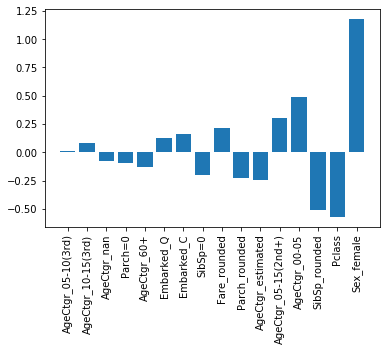

In [17]:
# model coefficient(Logistic regression)
model = model_tuning.best_estimator_
coef_df = pd.DataFrame(model.coef_.T)
feature_df = pd.DataFrame(X.columns)

model_df = pd.concat([feature_df, coef_df, abs(coef_df)], axis=1)
model_df.columns = ['feature_name', 'coef', 'coef_abs']
model_df = model_df.sort_values(by='coef_abs')

plt.xticks(rotation=90)
plt.bar(model_df.feature_name, model_df.coef)

In [18]:
# Validation時の推定値を求める
y_pred_prob = np.repeat(-1.0, len(y_train))
y_pred_flg = np.repeat(-1.0, len(y_train))

for train_index, valid_index in skf.split(X_scaled_train, y_train):
    X_cv_train, y_cv_train = X_scaled_train.iloc[train_index], y_train[train_index]
    X_cv_valid = X_scaled_train.iloc[valid_index]
    
    cv_model = LogisticRegression(solver='lbfgs', C=model_tuning.best_params_['C'])
    cv_model.fit(X_cv_train, y_cv_train)
    
    y_pred_prob[valid_index] = [p[1] for p in cv_model.predict_proba(X_cv_valid)]
    y_pred_flg[valid_index] = cv_model.predict(X_cv_valid)

           Survived  count
PredProb                  
00_0.0-0.1     9.8%     92
01_0.1-0.2    13.5%    288
02_0.2-0.3    10.9%     92
03_0.3-0.4    39.2%     51
04_0.4-0.5    41.2%     51
05_0.5-0.6    48.6%     74
06_0.6-0.7    67.3%     52
07_0.7-0.8    82.2%     73
08_0.8-0.9    93.9%     49
09_0.9-1.0    95.7%     69


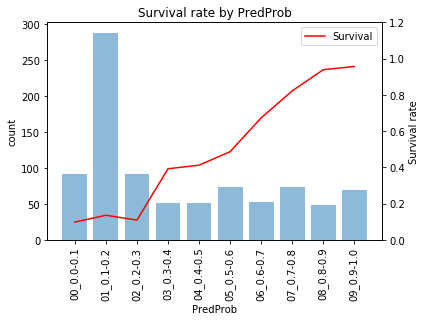

In [19]:
plot_df = pd.DataFrame(
    {'PredProb': y_pred_prob, 
     'Type': np.repeat('train', len(y_pred_prob)), 
     'Survived': y_train})

plot_survival_rate('PredProb', plot_df, np.linspace(0, 1, 11), label_format='{:02}_{:.1f}-{:.1f}')

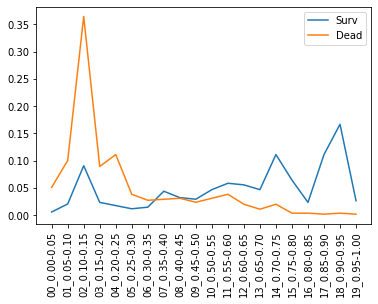

In [20]:
survived_flg = (y_train == 1)

survived_prob = y_pred_prob[survived_flg]
binned_prob = get_binned_data(survived_prob, bins=np.linspace(0, 1, 21), label_format='{:02}_{:.2f}-{:.2f}')

survived_count = binned_prob.value_counts().sort_index()
survived_rate = survived_count / sum(survived_count)

dead_prob = y_pred_prob[~survived_flg]
binned_prob = get_binned_data(dead_prob, bins=np.linspace(0, 1, 21), label_format='{:02}_{:.2f}-{:.2f}')

dead_count = binned_prob.value_counts().sort_index()
dead_rate = dead_count / sum(dead_count)

plt.xticks(rotation=90)
plt.plot(survived_rate)
plt.plot(dead_rate)
plt.legend(['Surv','Dead'])

In [21]:
# 予測結果を出力する
model = model_tuning.best_estimator_

y_pred = model.predict(X_scaled_test)
y_pred = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': y_pred})
y_pred.to_csv('./result/12_logistic_regression.csv', index=False)